# 1. 데이터 수집하기
---

In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data.sample(10)

,headlines,text
89019,Dwayne Johnson kisses Priyanka Chopra at Baywa...,Actor Dwayne Johnson kissed his Baywatch co-st...
60499,T'gana woman made to leave home for not making...,A 25-year-old woman in Telangana's Warangal on...
68498,Siemens sells Mumbai office property for Ã¢ÂÂ...,Engineering and technology firm Siemens on Mon...
20155,We're not making progress on N Korea denuclear...,US President Donald Trump on Friday said that ...
26793,"Hardik 1st Indian to take 4 wickets, slam 30+ ...",All-rounder Hardik Pandya became the first-eve...
80499,"Abducted, raped 13-year-old wants to return to...",The 13-year-old Delhi girl who was raped after...
79174,CAG criticises Indian Railways over dirty line...,The CAG has criticised Railways over improper ...
39415,Man bitten by head of severed snake that he ki...,A man in the US state of Texas required 26 dos...
87747,"MIT study compares rivers on Mars, Earth, Satu...",MIT Researchers studied three worlds in Solar ...
14175,It was still around? User tweets on Google+ sh...,Reacting to Google's announcement that it was ...


# 2. 데이터 전처리하기 (추상적 요약)
---
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

## 2.1 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines에서 중복을 배제한 유일한 샘플의 수', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines에서 중복을 배제한 유일한 샘플의 수 98280


In [6]:
# 중복 제거
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플 수 :', len(data))

전체 샘플 수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2.2 텍스트 정규화와 불용어 제거

In [9]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# 불용어(일반적인 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어) 제거

print('불용어 개수 : ', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수 :  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', '

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# 데이터 전처리 전,후 비교
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [13]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text=[]
clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary=[]
clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

184.85313081741333  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [14]:
# 데이터 전처리 후 빈 샘플이 생겼는지 확인 후 제거
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플 수 : ', len(data))

전체 샘플 수 :  98360


## 2.3 샘플의 최대 길이 정하기

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


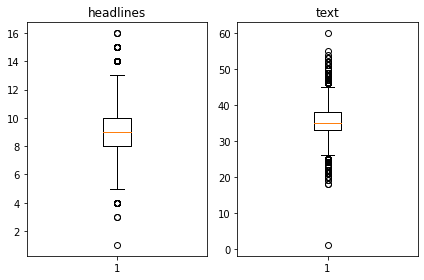

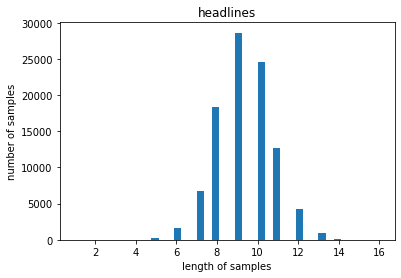

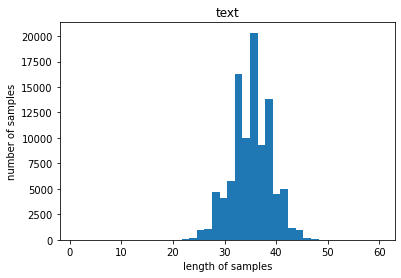

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
text_max_len = 45
summary_max_len = 12

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s' %(max_len, (cnt/len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율 : 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율 : 0.9880337535583571


In [21]:
data = data[data['text'].apply(lambda x:len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x:len(x.split()) <= summary_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


## 2.4 시작 토큰과 종료 토큰 추가하기

In [22]:
# 요약데이터에는 시작 큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
# 훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 
# 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요.

indicies = np.arange(encoder_input.shape[0])
np.random.shuffle(indicies)
print(indicies)

[18103 93819 28451 ... 69707 24207 79293]


In [25]:
encoder_input = encoder_input[indicies] 
decoder_input = decoder_input[indicies]
decoder_target = decoder_target[indicies]

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 : ', n_of_val)

테스트 데이터의 수 :  19374


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


## 2-5 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [29]:
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 trheshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if value<threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 : ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s' %(threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s' %(total_cnt-rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 :  69199
등장 빈도가 4번 이하인 희귀 단어의 수 : 43056
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 26143
단어 집합에서 희귀 단어의 비율 :  62.220552320120234
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  2.689875688031372


In [30]:
src_vocab = 6000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 6000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[80, 126, 2485, 2009, 1960, 2, 300, 1423, 32, 3482, 1297, 285, 18, 1347, 1347, 7, 103, 285, 397, 698, 24, 641, 999, 938, 124], [1879, 300, 1748, 1451, 1466, 50, 1347, 5228, 1227, 54, 30, 1451, 3255, 1347, 1329, 1778, 1601, 655, 2485, 1879, 30, 4, 34, 30, 42, 1879, 2289, 416, 1503, 1451, 971, 631, 246, 1052, 1373], [1093, 387, 181, 68, 980, 1306, 438, 2162, 2769, 94, 2365, 165, 145, 158, 399, 2148, 2162, 1037, 701, 920, 448, 30, 736, 5760, 5998, 802, 1127]]


In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29880
등장 빈도가 5번 이하인 희귀 단어의 수: 19512
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10368
단어 집합에서 희귀 단어의 비율: 65.3012048192771
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.700254475983357


In [34]:
tar_vocab = 5000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1841, 1342, 152, 50, 4, 1532, 153, 11, 1483], [1, 851, 1644, 53, 6, 145, 1292, 572, 59], [1, 818, 88, 424, 19, 1167, 3372], [1, 185, 2329, 2630, 2048, 3, 34, 1136, 501], [1, 1258, 77, 714, 1665, 181, 3, 244, 1686, 3736, 38]]
target
decoder  [[1841, 1342, 152, 50, 4, 1532, 153, 11, 1483, 2], [851, 1644, 53, 6, 145, 1292, 572, 59, 2], [818, 88, 424, 19, 1167, 3372, 2], [185, 2329, 2630, 2048, 3, 34, 1136, 501, 2], [1258, 77, 714, 1665, 181, 3, 244, 1686, 3736, 38, 2]]


## 2-6 빈도수가 낮은 단어 삭제 후 빈 샘플 제거

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 1


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 77496
훈련 레이블의 개수 : 77496
테스트 데이터의 개수 : 19373
테스트 레이블의 개수 : 19373


## 2-7 패딩하기

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 3. 어텐션 메커니즘 사용하기 (추상적 요약)
---
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

## 3-1 일반적인 seq2seq 모델

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      768000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 3-2 어텐션 매커니즘

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [41]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hideen state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      768000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 3-3 모델 훈련하기

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
                   validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
                   batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
152/152 [==============================] - 159s 967ms/step - loss: 5.5504 - val_loss: 4.7980
Epoch 2/50
152/152 [==============================] - 147s 970ms/step - loss: 4.7230 - val_loss: 4.4686
Epoch 3/50
152/152 [==============================] - 147s 967ms/step - loss: 4.4078 - val_loss: 4.2275
Epoch 4/50
152/152 [==============================] - 146s 963ms/step - loss: 4.1645 - val_loss: 4.0463
Epoch 5/50
152/152 [==============================] - 146s 961ms/step - loss: 3.9602 - val_loss: 3.8975
Epoch 6/50
152/152 [==============================] - 145s 956ms/step - loss: 3.7841 - val_loss: 3.7726
Epoch 7/50
152/152 [==============================] - 145s 952ms/step - loss: 3.6409 - val_loss: 3.6555
Epoch 8/50
152/152 [==============================] - 144s 950ms/step - loss: 3.5081 - val_loss: 3.5826
Epoch 9/50
152/152 [==============================] - 145s 952ms/step - loss: 3.3981 - val_loss: 3.5073
Epoch 10/50
152/152 [==============================] - 145s 952m

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있어요. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.

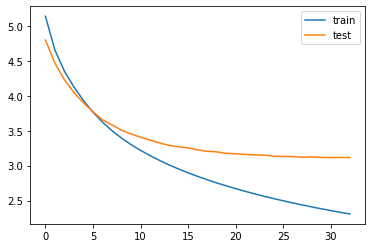

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 4. 실제 결과와 요약문 비교하기 (추상적 요약)
---
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.   
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.



## 4.1 인퍼런스 모델 구현

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수->단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어->정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수->단어를 얻음

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
            [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
            [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4-2 모델 테스트

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if i!=0:
            temp=temp+src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : german city least world indian cities ranked according survey indian cities bengaluru kolkata mumbai delhi notably four german cities feature list top 
실제 요약 : german cities least indian ranked over survey 
예측 요약 :  german city named world best cities


원문 : official twitter account icc used picture prince harry meghan markle royal wedding reaction rcb ab de villiers one handed catch icc placed picture wherein prince harry seen markle appears next picture de villiers taking catch 
실제 요약 : icc uses royal couple pic as reaction to abd catch 
예측 요약 :  markle shares pic with dhoni daughter in brazil


원문 : absconding liquor baron vijay mallya commenting appearance london court despite appearing judge last hearing said lawyers responding reporters regard new charges mallya said present whatever want respond notably mallya owes crore banks 
실제 요약 : do as my lawyers says vijay mallya 
예측 요약 :  no question of judge in london case mallya


원문 : andhra pradesh government entered understandi

# Step 5. Summa을 이용해서 추출적 요약해보기
---
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

* text (str) : 요약할 테스트.
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [107]:
from summa.summarizer import summarize

for i in range(50,200): 
    print("원문 :", seq2text(encoder_input_test[i])) 
    print("\n") 
    print("실제 요약 :", seq2summary(decoder_input_test[i])) 
    print("\n") 
    print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len))) 
    
    dot = 0 
    tmptxt = [] 
    for j in seq2text(encoder_input_test[i]).split() : 
        tmptxt.append(j) 
        dot += 1 
        if dot % 10 == 9: 
            tmptxt.append(".")
    print("\n") 
    print("추출적 요약:", summarize(' '.join(tmptxt), ratio=0.5))
    print('-'*100)

원문 : german city least world indian cities ranked according survey indian cities bengaluru kolkata mumbai delhi notably four german cities feature list top 


실제 요약 : german cities least indian ranked over survey 


추상적 요약 :  german city named world best cities


추출적 요약: german city least world indian cities ranked according survey .
----------------------------------------------------------------------------------------------------
원문 : official twitter account icc used picture prince harry meghan markle royal wedding reaction rcb ab de villiers one handed catch icc placed picture wherein prince harry seen markle appears next picture de villiers taking catch 


실제 요약 : icc uses royal couple pic as reaction to abd catch 


추상적 요약 :  markle shares pic with dhoni daughter in brazil


추출적 요약: official twitter account icc used picture prince harry meghan .
catch icc placed picture wherein prince harry seen markle appears .
-------------------------------------------------------------------

문법 완성도 측면에서는 추출적 요약보다 추상적 요약이 좀 더 깔끔하다. 아무래도 추출적 요약은 원문에서 있는 단어 들만 뽑아 오다 보니 요약적인 측면에서는 추상적 요약이 더 월등하다고 판단한다.

핵심단어 포함 측면에서는 추출적 요약이 추상적 요약 보다 더 잘 포함 된것 같다. 추출적 요약이 원문에 있는 단어로 만들기 때문이라고 판단한다.

# 회고
---

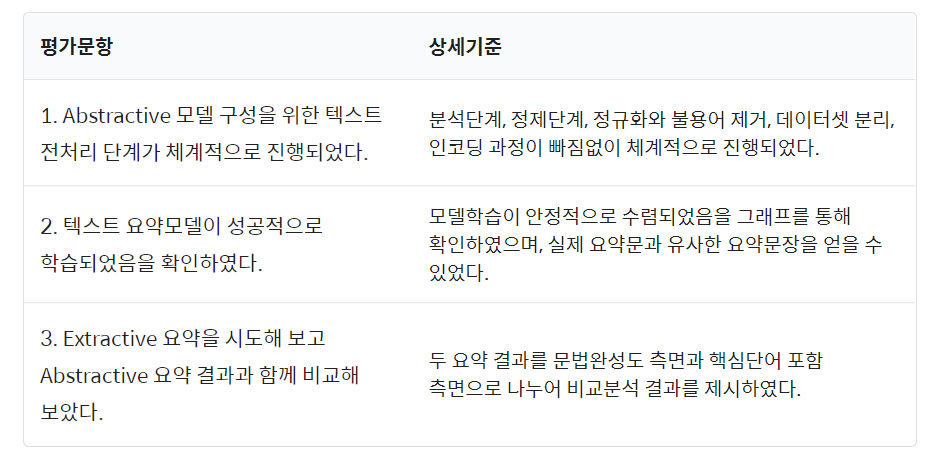

- 이번 프로젝트에서 **어려웠던 점,**        
    - 긴 모델 훈련 시간.

- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.       
    - 추출적, 추상적 요약에 대한 개념
    - seq2seq 모델에 대한 개념이 모호하다.

- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
    - 추출적, 추상적 요약에 대한 개념 자료 조사

- **자기 다짐**
    - RNN 아키텍쳐에 대한 개념을 복습하도록하자.